In [92]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
import json


dataframes = ["TheftEvent.parquet"]
attach_config_vars = ["generation_empty_w"]

folder = Path(".").resolve() / "data" / "experiments"
regex = r"(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})_(.+)_(\d{5})"


def load_experiments_by_name(name) -> dict[str, pd.DataFrame]:

    dfs = {dfname: [] for dfname in dataframes}

    for ent in folder.iterdir():

        if not ent.is_dir():
            continue

        res = re.match(regex, ent.name)
        
        if res is None:
            continue

        dstr, namestr, randstr = res.group(1), res.group(2), res.group(3)

        if namestr != name:
            continue

        if not (ent / "config.json").is_file():
            continue

        with open(ent / "config.json", "r", encoding="utf-8") as f:
            config = json.load(f)
        
        skip_log = not all([(ent / dfname).is_file() for dfname in dataframes])
    
        if skip_log:
            continue

        for dfname in dataframes:
            df = pd.read_parquet(ent / dfname) 
            df["rand"]= randstr
            
            for av in attach_config_vars:
                df[av] = config[av]
            
            dfs[dfname].append(df)

        

    
    dfs = {dfname: pd.concat(inners, ignore_index=True) for dfname, inners in dfs.items()}

    return dfs
        
df = load_experiments_by_name("vision_impr_thieves")["TheftEvent.parquet"]

In [93]:
df

,caught,thief_i,target_i,vision,cos_angle,t,rand,generation_empty_w
0,False,200,95,0.000000,-0.999223,272,42779,1.0
1,True,203,42,0.800000,0.892411,272,42779,1.0
2,True,210,108,1.000000,-0.584082,374,42779,1.0
3,True,209,71,0.187500,0.746712,425,42779,1.0
4,True,208,96,0.162044,0.985434,442,42779,1.0
...,...,...,...,...,...,...,...,...
73802,True,207,149,1.000000,-0.834365,118456,79048,70.0
73803,True,202,17,0.362500,0.176196,118507,79048,70.0
73804,True,205,183,0.387044,-0.802042,118745,79048,70.0
73805,False,208,49,1.000000,0.988508,118813,79048,70.0


Text(0, 0.5, 'N of thefts')

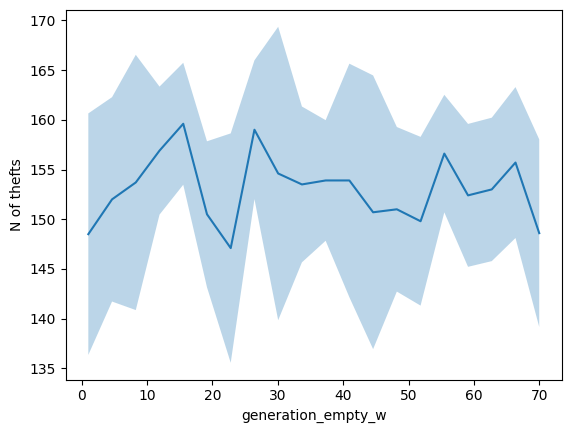

In [94]:
g = df.groupby(["rand", "generation_empty_w"])["caught"].value_counts()
g = g.reset_index()
g = g[~g["caught"]]

interest = "generation_empty_w"
def process(df: pd.DataFrame):
    return pd.DataFrame({"stole_mean": [df["count"].mean()], "stole_std": [df["count"].std()]})

g = g.groupby("generation_empty_w").apply(process)
g = g.reset_index().drop(columns="level_1")


fig, ax = plt.subplots()
ax.plot(g[interest], g["stole_mean"])
upper = g["stole_mean"] + g["stole_std"]
lower = g["stole_mean"] - g["stole_std"]

ax.fill_between(g[interest], upper, lower, alpha=0.3)
ax.set_xlabel(interest)
ax.set_ylabel("N of thefts")

<Axes: xlabel='generation_empty_w'>

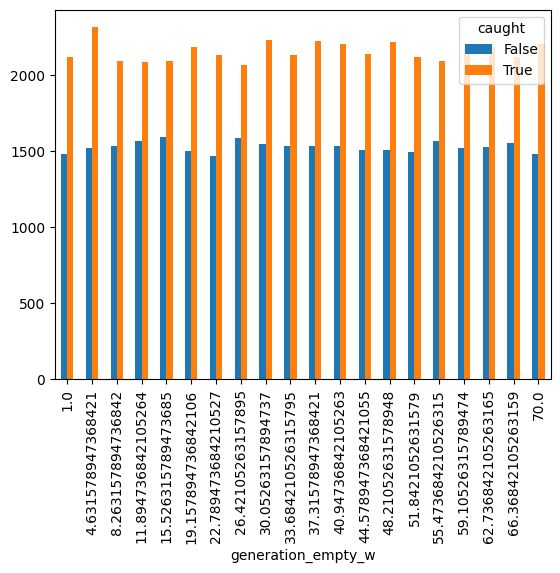

In [95]:
caught = df[df["caught"]]

df.groupby(interest)["caught"].value_counts().unstack().plot.bar()

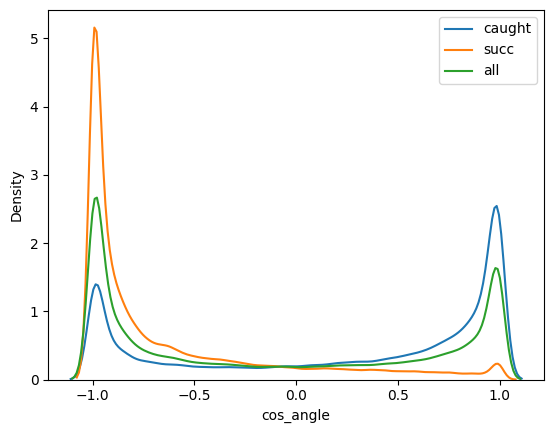

In [96]:
import seaborn as sns
from matplotlib import pyplot as plt


fig, ax = plt.subplots()

sns.kdeplot(df.loc[df["caught"], "cos_angle"], bw_adjust=0.4, ax=ax, label="caught")
sns.kdeplot(df.loc[~df["caught"], "cos_angle"], bw_adjust=0.4, ax=ax, label="succ")
sns.kdeplot(df.loc[:, "cos_angle"], bw_adjust=0.4, ax=ax, label="all")

ax.legend()
plt.show()